<div style="padding-right: 2rem; padding-bottom: 2rem; width: 100px; height: 100px; align: left;">
<img src="https://sales.captor.se/captor_logo_sv_1600_icketransparent.png" alt="Captor Fund Management AB"/>
</div>
<div>
  <h3>An introduction to the <a href="https://pypi.org/project/openseries/">openseries</a> Python package</h3>
</div>

First we set it all up

In [1]:
import datetime as dt
import requests
from plotly.offline import init_notebook_mode, iplot

from openseries.series import OpenTimeSeries
from openseries.types import ValueType
from openseries.simulation import ReturnSimulation
from openseries.frame import (
    OpenFrame,
    efficient_frontier,
    prepare_plot_data,
    sharpeplot,
)

seed = 55
init_notebook_mode()

We define a function to fetch data from an external API

In [2]:
def get_fund_nav(isin_code: str) -> OpenTimeSeries:

    response = requests.get(url="https://api.qipple.com/public/api/nav")

    if response.status_code // 100 != 2:
        raise Exception(f"{response.status_code}, {response.text}")

    data = {}
    result = response.json()
    for res in result:
        if res["isin"] == isin_code:
            data.update(res)

    if len(data) == 0:
        raise Exception(
            f"Request for NAV series using ISIN {isin_code} returned no data."

        )

    return OpenTimeSeries.from_arrays(
        name=data["longName"],
        timeseries_id=data["_id"],
        baseccy=data["currency"],
        dates=data["dates"],
        values=data["navPerUnit"],
        valuetype=ValueType.PRICE,
    )

Here we fetch NAV (price per unit) for some of the Captor mutual funds

In [3]:
basket = OpenFrame(
    [
        get_fund_nav(isin_code="SE0015243886"),
        get_fund_nav(isin_code="SE0011337195"),
        get_fund_nav(isin_code="SE0011670843"),
        get_fund_nav(isin_code="SE0017832280"),
        get_fund_nav(isin_code="SE0017832330"),
    ]
)
basket = basket.value_nan_handle().trunc_frame().to_cumret()

We then make a portfolio of the funds based on a weight strategy

In [4]:
portfolio = OpenTimeSeries.from_df(basket.make_portfolio(name="Portfolio", weight_strat="eq_weights"))
basket = basket.add_timeseries(portfolio)

And create and display a Plotly plot of all the data

In [5]:
figure, _ = basket.plot_series(tick_fmt=".1%", auto_open=False, output_type="div", add_logo=False)
figure = figure.update_layout(
    height=600, 
    font_size=10, 
    legend=dict(
        yanchor="bottom", 
        y=-0.3, 
        xanchor="right", 
        x=0.98, 
        orientation="h"
    )
)
iplot(figure, link_text="")

Here we calculate and display a Pandas Dataframe with some analyses

In [6]:
df = basket.all_properties(properties=[
        "arithmetic_ret",
        "vol",
        "ret_vol_ratio",
        "sortino_ratio",
        "worst_month",
        "cvar_down",
        "first_indices",
        "last_indices",
    ]
)

In [7]:
df.columns = df.columns.droplevel(level=1)

formats = [
        "{:.2%}",
        "{:.2%}",
        "{:.2f}",
        "{:.2f}",
        "{:.2%}",
        "{:.2%}",
        "{:%Y-%m-%d}",
        "{:%Y-%m-%d}",
    ]

for item, f in zip(df.index, formats):
    df.loc[item] = df.loc[item].apply(
        lambda x: x if isinstance(x, str) else f.format(x)
    )
df

Captor Aster Global Credit Captor Dahlia Green Bond  \
Arithmetic return                      6.90%                    4.10%   
Volatility                             9.26%                    3.59%   
Return vol ratio                        0.74                     1.14   
Sortino ratio                           1.11                     1.83   
Worst month                           -5.49%                   -1.82%   
CVaR 95.0%                            -1.27%                   -0.46%   
first indices                     2022-12-06               2022-12-06   
last indices                      2024-05-08               2024-05-08   

                  Captor Scilla Global Equity Captor Aster Global High Yield  \
Arithmetic return                      13.12%                         12.73%   
Volatility                              8.92%                          7.31%   
Return vol ratio                         1.47                           1.74   
Sortino ratio                            2.14                           2.63   
Worst month                            -2.61%                         -2.46%   
CVaR 95.0%                             -1.30%                         -1.07%   
first indices                      2022-12-06                     2022-12-06   
last indices                       2024-05-08                     2024-05-08   

                  Captor Aster Global Credit Short-Term   Portfolio  
Arithmetic return                                 6.30%       8.63%  
Volatility                                        1.68%       4.35%  
Return vol ratio                                   3.75        1.98  
Sortino ratio                                      5.78        3.00  
Worst month                                       0.02%      -2.44%  
CVaR 95.0%                                       -0.26%      -0.61%  
first indices                                2022-12-06  2022-12-06  
last indices                                 2024-05-08  2024-05-08

Below we illustrate the portfolio simulation tools in the package. We first simulate 4 assets.

In [8]:
series = ReturnSimulation.from_merton_jump_gbm(
    number_of_sims=4,
    trading_days=2512,
    mean_annual_return=0.05,
    mean_annual_vol=0.1,
    jumps_lamda=0.1,
    jumps_sigma=0.3,
    jumps_mu=-0.2,
    trading_days_in_year=252,
    seed=seed,
)
assets = OpenFrame(
    [
        OpenTimeSeries.from_df(
            series.to_dataframe(name="Asset", end=dt.date(2023, 12, 29)),
            column_nmbr=serie,
        )
        for serie in range(series.number_of_sims)
    ],
).to_cumret()

We then simulate portfolio weights and find the efficient frontier and optimal portfolio using return over volatility as the target measure.

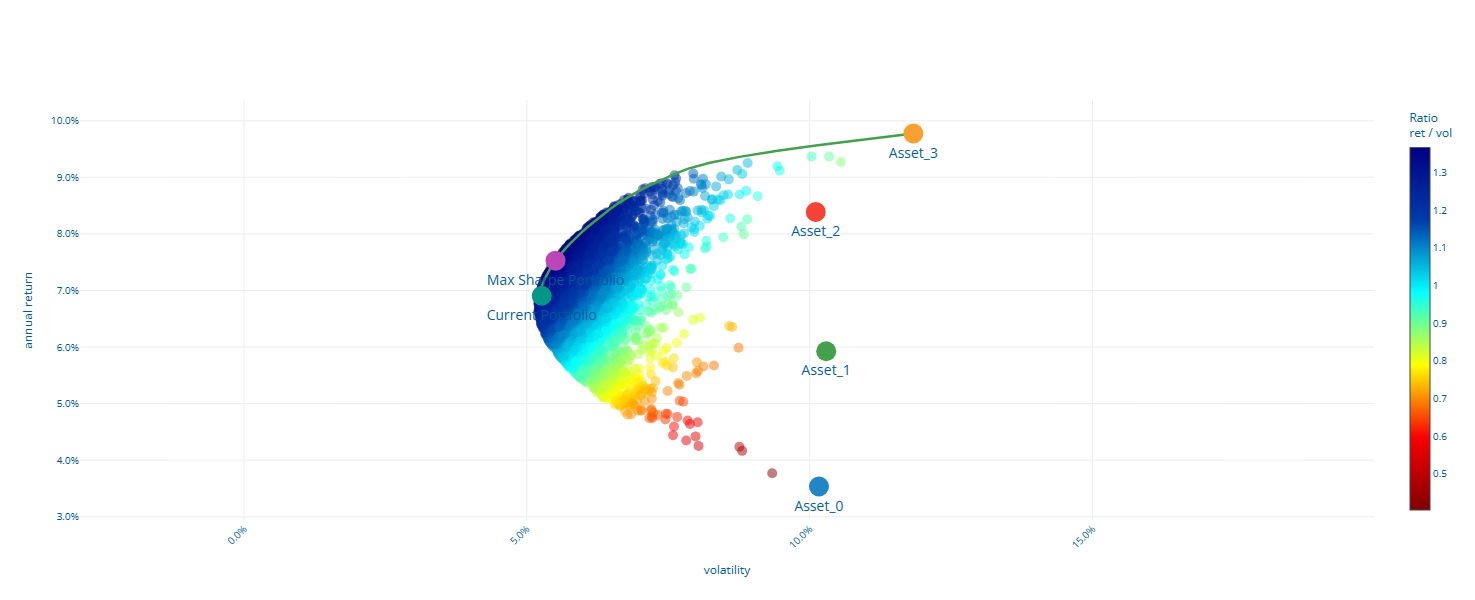

In [9]:
simulations = 5000
points = 30

current = OpenTimeSeries.from_df(
    assets.make_portfolio(
        name="Current Portfolio",
        weight_strat="eq_weights",
    ),
)
frontier, simulated, optimum = efficient_frontier(
    eframe=assets,
    num_ports=simulations,
    seed=seed,
    frontier_points=points,
)
plotframe = prepare_plot_data(
    assets=assets,
    current=current,
    optimized=optimum,
)
simfigure, _ = sharpeplot(
    sim_frame=simulated,
    line_frame=frontier,
    point_frame=plotframe,
    point_frame_mode="markers+text",
    title=False,
    add_logo=False,
    auto_open=False,
    output_type="div",
)
simfigure = simfigure.update_layout(font_size=10, height=600)
iplot(simfigure, link_text="")